In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import shap
import xgboost

# Prédictions sur les gaz à effet de serre

Bienvenue dans ce troisième notebook pour le projet 4 de la formation Data Scientist.

Les conclusions étant données sur l'énergie, on va essayer de voir si on obtient des résultats similaires pour les gaz à effets de serre.

On utilise les mêmes features pour prédire, et la target est à nouveau passée au logarithme. Le notebook sera donc très simialire, et je vais naturellement user du copier/coller par rapport au notebook précédent.

## Préparation des données

La préparation est exactement la même que lors du notebook précédent. Je vais donc reproduire les mêmes opérations, à ceci près que la target ne sera pas située sur la même colonne.

In [2]:
# Commençons par récupérer nos données

data = pd.read_csv("ready.csv")
data.head()

,OSEBuildingID,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,Age,logEnergyUse,logGHG
0,1,Hotel,DOWNTOWN,12,88434,60.0,88,15.824652,5.521381
1,2,Hotel,DOWNTOWN,11,103566,61.0,19,15.974742,5.689886
2,3,Hotel,DOWNTOWN,41,956110,43.0,46,18.118725,7.644575
3,5,Hotel,DOWNTOWN,10,61320,56.0,89,15.753792,5.657494
4,8,Hotel,DOWNTOWN,18,175580,75.0,35,16.500395,6.224578


In [3]:
Y = data["logGHG"].round(3) 
Y

0       5.521
1       5.690
2       7.645
3       5.657
4       6.225
        ...  
1578    3.042
1579    3.471
1580    5.410
1581    3.096
1582    3.720
Name: logGHG, Length: 1583, dtype: float64

In [4]:
X = data.loc[:, ["PrimaryPropertyType","Neighborhood","NumberofFloors","PropertyGFATotal","Age"]] #Sans ENERGYSTAR pour l'instant
X

,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,Age
0,Hotel,DOWNTOWN,12,88434,88
1,Hotel,DOWNTOWN,11,103566,19
2,Hotel,DOWNTOWN,41,956110,46
3,Hotel,DOWNTOWN,10,61320,89
4,Hotel,DOWNTOWN,18,175580,35
...,...,...,...,...,...
1578,Small- and Mid-Sized Office,GREATER DUWAMISH,1,12294,25
1579,Other,DOWNTOWN,1,16000,11
1580,Other,MAGNOLIA / QUEEN ANNE,1,13157,41
1581,Mixed Use Property,GREATER DUWAMISH,1,14101,26


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, stratify = X["PrimaryPropertyType"])

On réutilise aussi l'outil créé précédemment pour les variables numériques / catégorielles

In [6]:
numeric_features = ["NumberofFloors","PropertyGFATotal","Age"]

categorical_features = ["PrimaryPropertyType","Neighborhood"]

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

In [7]:
X_scaled = transformer.fit_transform(X_train)
X_scaled

features = transformer.get_feature_names_out() #En vérité, je n'ai besoin de ceci que beaucoup plus tard, lors de l'analyse de feature importances.

In [8]:
X_test_scaled = transformer.fit_transform(X_test)
X_test_scaled

<238x34 sparse matrix of type '<class 'numpy.float64'>'
	with 1190 stored elements in Compressed Sparse Row format>

J'ai tout de même supprimé les vérifications afin d'alléger le temps de lecture.

Les données sont maintenant tout à fait prêtes pour effectuer des prédictions.

## Erreur utilisée pour les prédictions

Comme pour l'énergie, je vais chercher à optimiser la MSE, puis dans un second temps jeter un oeil au r².
C'est parti pour tous les modèles différents, comme la première fois.

## Baseline

En tant que baseline, je vais utiliser un "dummy" correspondant à la moyenne.

In [9]:
dummy_clf = DummyRegressor(strategy="mean")
dummy_clf.fit(X_scaled, Y_train)

DummyRegressor()

In [10]:
Y_pred = dummy_clf.predict(X_test_scaled)
mse_baseline = mean_squared_error(Y_pred,Y_test)
mse_baseline
#Sur plusieurs essais, la MSE ici oscille entre 1.7 et 1.9

2.2756979565948394

In [11]:
rmse_baseline = mean_squared_error(Y_pred,Y_test, squared = False)
mae_baseline = mean_absolute_error(Y_pred,Y_test)
r2_baseline = r2_score(Y_pred,Y_test)

#Je crée un dataframe qui me servira plus tard, dans lequel je stocke les erreurs de mes modèles.
errors = {'Algorithm': ['Dummy Mean'],
        'Best MSE': mse_baseline,
         'RMSE' : rmse_baseline,
          'MAE' : mae_baseline,
          'r2' : r2_baseline
         }

errors = pd.DataFrame(errors)

## Fonction traitant un type d'algorithme entièrement

Pour alléger, à nouveau, ce notebook ci, je ne re-traite pas de nouveau le cas du k-NN séparément au départ.

Je reprends ma fonction directement. Rien ne change par rapport à la nouvelle target.

Pour la suite, je laisse mes commentaires tels quels du copier/coller, je reprends à l'affichage du tableau "errors".

In [12]:
def test_this_model (model, params):
    #Tout d'abord, je veux connaître ma MSE initiale, sans validation croisée.
    base = model()
    base.fit(X_scaled,Y_train)
    base_error = mean_squared_error(base.predict(X_test_scaled),Y_test)
    print("MSE de base : {:.3f}".format(base_error))
    
    #Ensuite, je veux effectuer une GridSearchCV avec les paramètres que j'ai spécifiés, et récupérer les meilleurs
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error').fit(X_scaled,Y_train)
    bestmodel = model(**grid.best_params_).fit(X_scaled, Y_train)
    
    #Maintenant, je calcule la MSE avec mon modèle optimal et je l'affiche.
    Y_pred = bestmodel.predict(X_test_scaled)
    Best_error = mean_squared_error(Y_pred,Y_test)
    print("Meilleure MSE : {:.3f}".format(Best_error))
    
    #J'aimerais aussi afficher mes meilleurs paramètres.
    print(f"Meilleurs paramètres : {grid.best_params_}" )
    
    #Enfin, je remplis mon dataframe "errors"
    rmse_model = mean_squared_error(Y_pred,Y_test, squared = False)
    mae_model = mean_absolute_error(Y_pred,Y_test)
    r2_model = r2_score(Y_pred,Y_test)

    new_row = {'Algorithm': 'à remplacer', #Je souhaite afficher des noms plus clairs que juste "model", je le ferai hors-fonction
            'Best MSE': Best_error,
             'RMSE' : rmse_model,
              'MAE' : mae_model,
              'r2' : r2_model
             }

    errors.loc[len(errors)] = new_row
    
    #Renvoie le meilleur modèle
    return(bestmodel)

On teste la fonction avec le modèle K-NN et des paramètres :

In [13]:
params = {
        'n_neighbors' : range(1,30),
        'weights' : ['uniform','distance'],
        'p' : [1,2]
        }

bestknn = test_this_model(KNeighborsRegressor, params)

MSE de base : 1.524
Meilleure MSE : 1.404
Meilleurs paramètres : {'n_neighbors': 12, 'p': 2, 'weights': 'uniform'}


## Modèles linéaires

### Régression linéaire

Pourquoi pas une simple régression linéaire ? Après tout, lors de l'analyse, on a observé un très beau scatterplot entre le logGFA et nos targets. Essayons et voyons ce que cela donne.

Pas de paramètres pour une validation croisée, en revanche.



In [14]:
params = {}

linreg = test_this_model(linear_model.LinearRegression, params)

MSE de base : 1.425
Meilleure MSE : 1.425
Meilleurs paramètres : {}


Je concède volontiers que je ne m'attendais pas du tout à cela.
Il semblerait que, bien que cette régression reste assez simple, elle soit déjà plus performante que notre meilleur K-NN. (Quelques relances m'ont prouvé le contraire, mais elle reste au moins aussi performante).

Il semblerait donc qu'un modèle linéaire soit relativement adapté. Allons regarder du côté des régressions plus complexes.

### Régression ridge

In [15]:
#Pour la régression ridge, je vais jouer sur alpha et sur le solver
params = {
        'alpha' : np.logspace(-4,2,20),
        'solver' : ['svd','cholesky','lsqr','sparse_cg','sag','saga','lbfgs'],
        'positive' : [True,False],
        'fit_intercept' : [False]
        }

ridgereg = test_this_model(linear_model.Ridge, params)

MSE de base : 1.423
Meilleure MSE : 1.422
Meilleurs paramètres : {'alpha': 0.29763514416313164, 'fit_intercept': False, 'positive': False, 'solver': 'lsqr'}



800 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Yann\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Yann\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 1011, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\Yann\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 712, in fit
    raise ValueError(
ValueError: solver='svd' does not support positive fitting. Please set the solver to 'auto' or 'lbfgs', or set `positive=False`

--

On a quelques erreurs dûes aux incompatibilités de paramètres, mais le plus surprenant ici, c'est que la "Meilleure MSE" est... moins bonne que l'initiale ! Et a peu près similaire dans les deux cas à la régression linéaire simple. Il semblerait que la régularisation ridge n'apporte pas grand chose.

### Lasso

Reprenons les mêmes procédés avec le lasso.

In [16]:
params = {
        'alpha' : np.logspace(-4,2,50),
        'fit_intercept' : [False],
        'max_iter' : [5000]
        }

bestlasso = test_this_model(linear_model.Lasso, params)

MSE de base : 2.276


Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.343129728983058, tolerance: 1.9401722717999998


Meilleure MSE : 1.422
Meilleurs paramètres : {'alpha': 0.00040949150623804275, 'fit_intercept': False, 'max_iter': 5000}


A nouveau, avec plusieurs relances, le lasso n'est pas très convaincant non plus. Qu'à cela ne tienne, nous ne sommes pas à court d'idées.

### Elastic net

Combinons donc le ridge et le lasso pour obtenir, normalement, la meilleure version possible de notre régression linéaire.

In [17]:
elastic = linear_model.ElasticNet(fit_intercept = False, max_iter = 50000) 

In [18]:
params = {
        'alpha' : np.logspace(-5,-3,3),
        'l1_ratio' : np.linspace(0.5,0.99,5),
        'fit_intercept' : [False],
        'max_iter' : [50000]
    }

bestlastic = test_this_model(linear_model.ElasticNet, params)

MSE de base : 2.091
Meilleure MSE : 1.422
Meilleurs paramètres : {'alpha': 0.001, 'fit_intercept': False, 'l1_ratio': 0.745, 'max_iter': 50000}


##### Conclusion sur la régularisation

Sur 3 relances globales pour modifier mon train/test/split, la différence entre ces deux erreurs... n'est pas flagrante. Elle est même fréquemment favorable à la régression linéaire simple. La régularisation, qu'elle soit ridge, lasso, ou bien encore de type ElasticNet, n'apporte rien à mes prédictions sur ce dataset.

### SVM Linéaire

A l'origine, la SVM s'occupe de problèmes de classification. Mais on peut aussi l'utiliser pour de la régression.

Essayons.

In [19]:
# Comme j'ai plus d'individus que de features, je préfère le problème primal au dual

params = {
        'epsilon' : np.linspace(0,0.3,4),
        'C' : np.logspace(-2,3,6),
        'dual' : [False],
        'fit_intercept' : [False],
        'loss' : ['squared_epsilon_insensitive']
    }

bestlinearsvr = test_this_model(LinearSVR, params)

MSE de base : 1.449
Meilleure MSE : 1.424
Meilleurs paramètres : {'C': 10.0, 'dual': False, 'epsilon': 0.0, 'fit_intercept': False, 'loss': 'squared_epsilon_insensitive'}


C'est... Sensiblement la même erreur que pour mes régressions linéaires précédentes.

Il semblerait que, en ce qui concerne les modèles linéaires, nous soyons limités à cette performance.

## Modèles non linéaires

### SVM à noyau

Essayons de modifier notre approche, en utilisant des modèles non nécessairement linéaires.

On peut le faire, par exemple, avec une SVM à noyau.

Il y a plusieurs noyaux possibles, beaucoup d'erreurs seront affichées à cause d'incompatibilités, mais lançons nous.
Je vais tester un par un les différents noyaux possibles, car il semblerait que tout tester d'un coup plante la machine.

In [20]:
params = {
        'gamma' : np.logspace(-3,0,4),
        'C' : np.logspace(0,3,4),
        'epsilon' : [0.05,0.1,0.15],
        'kernel' : ['rbf']
    }

bestrbfsvr = test_this_model(SVR, params)

MSE de base : 1.285
Meilleure MSE : 1.267
Meilleurs paramètres : {'C': 100.0, 'epsilon': 0.15, 'gamma': 0.01, 'kernel': 'rbf'}


Pour la première fois, nous observons des progrès significatifs au niveau de la MSE. C'est très encourageant.
Essayons maintenant les autres noyaux.

In [21]:
params = {
        'gamma' : np.logspace(-3,0,4),
        'C' : np.logspace(0,3,4),
        'epsilon' : [0.05,0.1,0.15],
        'coef0' : np.logspace(-3,-1,3),
        'kernel' : ['sigmoid']
    }

bestsigmoid = test_this_model(SVR, params)

MSE de base : 1.285
Meilleure MSE : 1.512
Meilleurs paramètres : {'C': 100.0, 'coef0': 0.001, 'epsilon': 0.15, 'gamma': 0.001, 'kernel': 'sigmoid'}


On ne va définitivement pas conserver ce noyau. On pouvait s'en douter, puisque l'analyse des données ne nous a pas vraiment fait penser à une sinusoïde.
Ici, l'erreur "de base" est moins grande que l'erreur "optimisée". C'est parce que le noyau utilisé de "base" n'est pas le sigmoïde mais le "rbf".

Essayons enfin un noyau polynômial.
(En fait, pour une raison que j'ignore, et malgré plusieurs essais différents, je ne parviens pas à faire fonctionner le noyau polynômial pour la SVR. En revanche, le noyau polynômial est accessible pour le prochain modèle, donc je m'en contenterai).

### kRR (Kernel ridge regression)

Encore une fois, plusieurs noyaux sont possibles. Commençons par le noyau polynômial.

Cette fois-ci, le noyau "de base" est "linear". Comme pour le SVR à noyau sigmoid juste avant, on ne le prendra pas trop en compte ici.

In [22]:
params = {
        'degree' : [3,4],
        'gamma' : np.logspace(-2,1,4),
        'alpha' : np.logspace(0,3,4),
        'coef0' : np.logspace(-1,2,4),
        'kernel' : ['poly']
    }

bestkrrpoly = test_this_model(KernelRidge, params)

MSE de base : 1.421
Meilleure MSE : 1.249
Meilleurs paramètres : {'alpha': 1000.0, 'coef0': 10.0, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}


On obtient une MSE compétitive avec la meilleure trouvée jusqu'ici (avec la première SVR à noyau), dépendamment des relances du notebook, elle est parfois meilleure, parfois moins bonne.

In [23]:
# test noyau rbf

params = {
        'gamma' : np.logspace(-4,1,6),
        'alpha' : np.logspace(-3,3,7),
        'kernel' : ['rbf']
    }

bestkrrrbf = test_this_model(KernelRidge, params)

MSE de base : 1.421
Meilleure MSE : 1.242
Meilleurs paramètres : {'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


C'est également un modèle compétitif avec les deux précédents. On obtient des valeurs assez équivalentes avec les différentes relances.

### Forêt aléatoire

Puisque dans les cours proposés, j'ai également pu voir cette méthode, essayons de prédire avec des arbres de décision et du bagging.



In [24]:
params = {'n_estimators' : [100, 500, 1000], #Il est très long d'en tester plus. Je l'ai fait, et les résultats ne changent pas. Je vous l'épargne donc.
         'n_jobs' : [-1]} 

bestforest = test_this_model(RandomForestRegressor, params) #Le modèle "de base" est avec n_estimators = 100

MSE de base : 1.423
Meilleure MSE : 1.379
Meilleurs paramètres : {'n_estimators': 500, 'n_jobs': -1}


En vérité, on constate très peu de différence en terme de MSE au-delà de n_estimators = 100. En terme de temps d'entraînement il est bien meilleur, il est donc largement satisfaisant.

On constate, en terme de performance, que la forêt aléatoire fait presque aussi bien que nos meilleurs modèles jusqu'ici. pas aussi bien, mais beaucoup mieux que les modèles linéaires par exemple. 

##### Petit aparté

On constate fréquemment, et alors que ça ne devrait pas du tout avoir lieu, des meilleures performances pour les MSE "de base" que pour les "meilleures". En fait, c'est à cause de la variance de mon train/test/split original, et aussi d'un certain overfitting. En relançant le notebook, on trouve parfois des "MSE de base" un peu meilleures que les "meilleures", mais aussi parfois BEAUCOUP moins bonnes. En moyenne, et c'est plutôt rassurant, les "Meilleures" MSE sont réellement meilleures.

### Boosting

En fait, j'aimerais tester plusieurs choses : un régresseur à gradient qui part de rien, et un qui part de mon meilleur résultat actuel, pour voir s'il l'améliore ou non.

In [25]:
params = {
    'learning_rate' : np.logspace(-3,-1,3),
    'n_estimators' : [100, 500, 1000]
}

bestgbr = test_this_model(GradientBoostingRegressor, params)

MSE de base : 1.309
Meilleure MSE : 1.305
Meilleurs paramètres : {'learning_rate': 0.1, 'n_estimators': 100}


Maintenant, que se passe-t-il si je l'initialise avec mes "meilleurs" résultats ?

In [26]:
params = {
    'init' : [bestkrrpoly, bestkrrrbf, bestrbfsvr], #Ces trois là sont toujours les meilleurs et assez proches
    'learning_rate' : np.logspace(-3,-1,3),
    'n_estimators' : [100, 500, 1000]
}

realbestgbr = test_this_model(GradientBoostingRegressor, params)

MSE de base : 1.308
Meilleure MSE : 1.213
Meilleurs paramètres : {'init': KernelRidge(alpha=0.01, gamma=0.01, kernel='rbf'), 'learning_rate': 0.01, 'n_estimators': 100}


Ce n'est pas toujours le cas, mais la plupart du temps, la MSE affichée ici est la meilleure de toutes. Le boosting me permet ici de retirer entre 2 et 4% à ma meilleure MSE, et donc, lorsque bien initialisé, c'est lui qui me permet d'obtenir le meilleur algorithme de prédiction (sans utilisation de l'ENERGY STAR score).

### Bilan des tests des différents algorithmes

In [27]:
#On peut maintenant regarder l'ensemble de nos algorithmes et leurs meilleures performances (en terme de MSE)
errors

,Algorithm,Best MSE,RMSE,MAE,r2
0,Dummy Mean,2.275698,1.508542,1.177341,-1.282129e+30
1,à remplacer,1.404319,1.185039,0.902079,-6.643665e-01
2,à remplacer,1.424675,1.193597,0.906062,-4.890504e-01
3,à remplacer,1.422105,1.192520,0.906528,-5.027743e-01
4,à remplacer,1.422276,1.192592,0.906688,-4.967512e-01
5,à remplacer,1.421566,1.192294,0.908746,-5.113557e-01
6,à remplacer,1.424165,1.193384,0.906190,-4.906589e-01
7,à remplacer,1.267028,1.125623,0.854750,-1.857151e-01
8,à remplacer,1.512101,1.229675,0.918581,-7.762347e-01
9,à remplacer,1.249480,1.117801,0.864732,-1.190681e-01


In [28]:
#Comme annoncé dans l'écriture de ma fonction test_this_model, je dois à présent renommer les "à remplacer"
errors["Algorithm"] = ["Dummy Mean", "KNN", "Basic Linear Regression", "Ridge Regression","Lasso Regression","ElasticNet","Linear SVR","rbf SVR","sigmoid SVR","polynomial KRR","rbf KRR","random forest","Gradient Boosting (Base)","Gradient Boosting from best models"]

In [29]:
#On peut maintenant trier selon les performances
errors = errors.sort_values('Best MSE').reset_index(drop = True)
errors

,Algorithm,Best MSE,RMSE,MAE,r2
0,Gradient Boosting from best models,1.213314,1.101505,0.851952,5.403922e-02
1,rbf KRR,1.241997,1.114449,0.862341,-4.212372e-02
2,polynomial KRR,1.249480,1.117801,0.864732,-1.190681e-01
3,rbf SVR,1.267028,1.125623,0.854750,-1.857151e-01
4,Gradient Boosting (Base),1.304898,1.142321,0.869996,-8.335960e-02
5,random forest,1.378942,1.174284,0.886141,8.031506e-03
6,KNN,1.404319,1.185039,0.902079,-6.643665e-01
7,ElasticNet,1.421566,1.192294,0.908746,-5.113557e-01
8,Ridge Regression,1.422105,1.192520,0.906528,-5.027743e-01
9,Lasso Regression,1.422276,1.192592,0.906688,-4.967512e-01


### Bilan intermédiaire (par rapport au EnergyUse)

Que dire par rapport à la première target ? 
Premièrement, les meilleurs modèles sont les mêmes (noyaux rbf ou polynômiaux, gradient boosting).

Deuxièmement, les résultats obtenus sont *beaucoup* moins satisfaisants. Que ce soit en terme de MSE minimale (2 fois plus importante que pour l'énergie), qu'en terme de R² (le maximum peine à dépasser 0.3, même avec plusieurs relances du notebook et donc tu train/test/split).

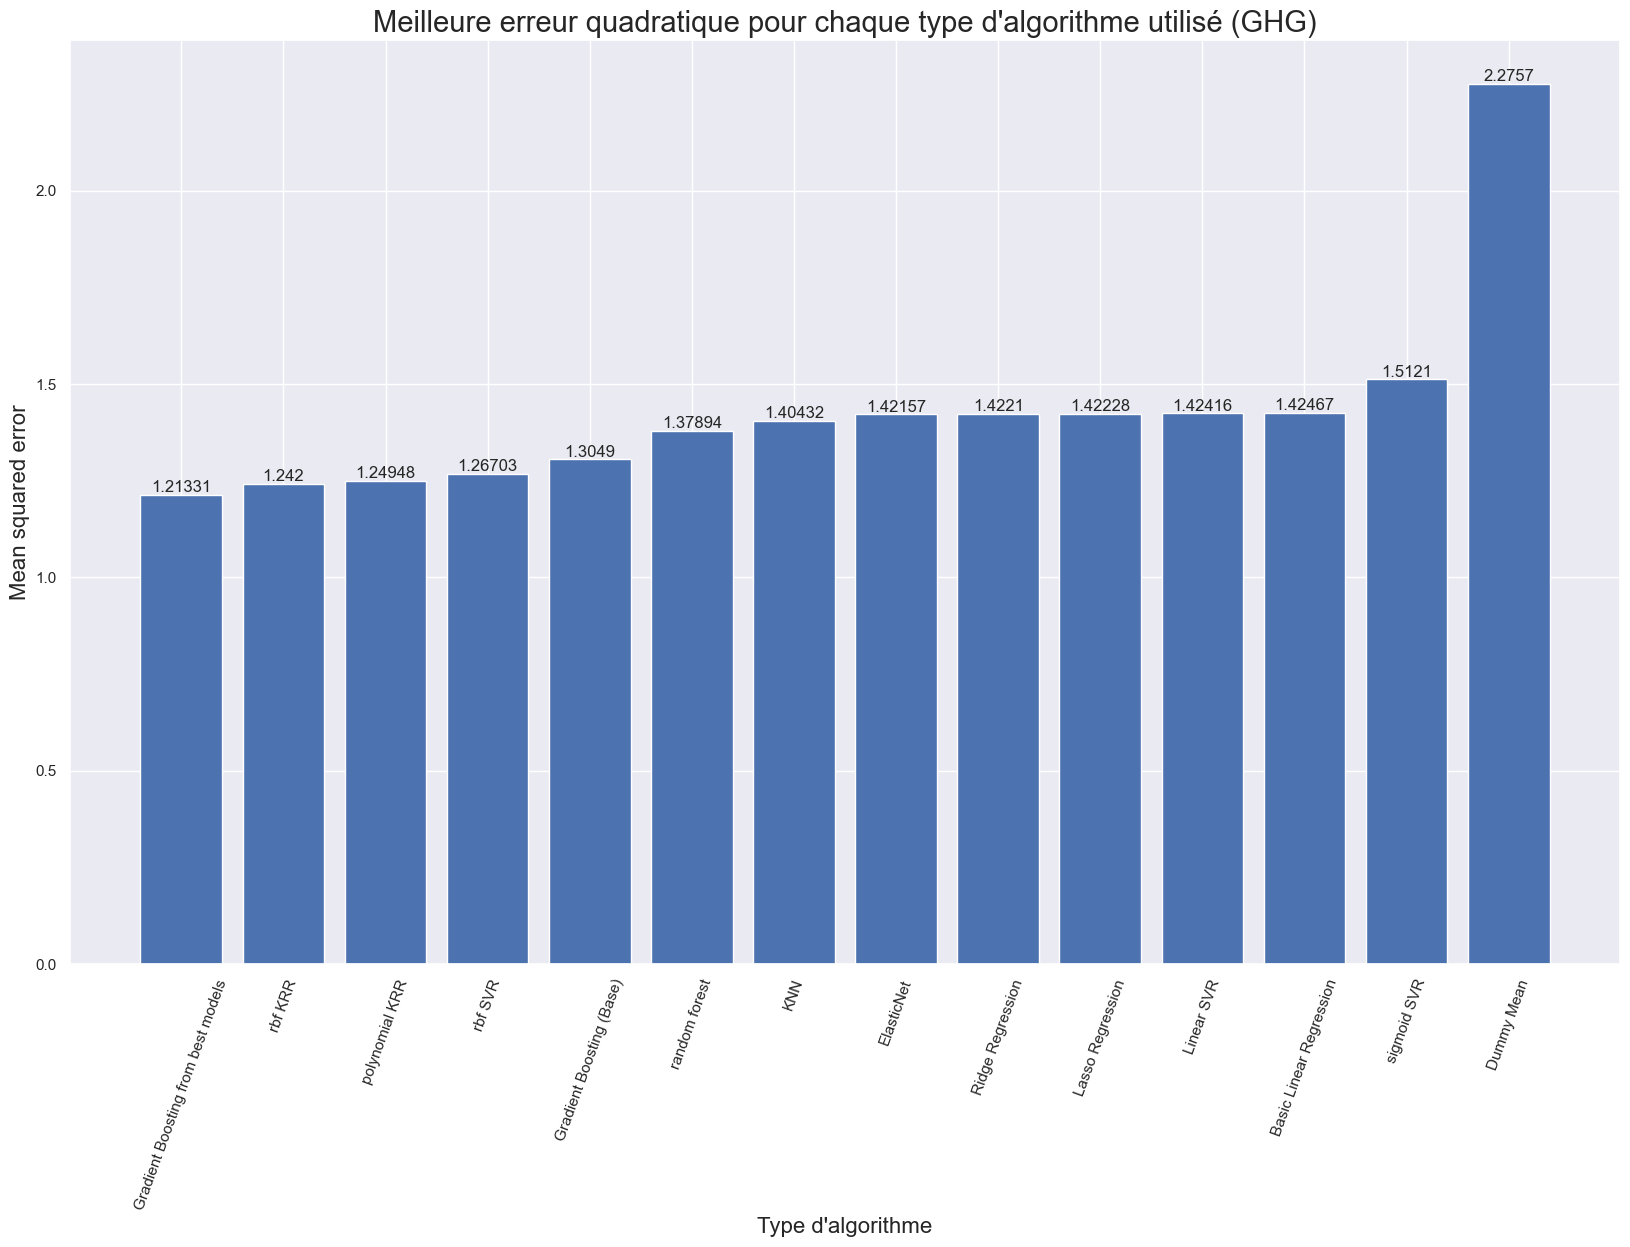

In [30]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(20, 12))
bars = plt.bar(errors["Algorithm"], errors["Best MSE"])
ax.bar_label(bars)
plt.title("Meilleure erreur quadratique pour chaque type d'algorithme utilisé (GHG)", fontsize = 21)
plt.xlabel("Type d'algorithme", fontsize = 16)
plt.xticks(rotation = 70)
plt.ylabel("Mean squared error", fontsize = 16)
plt.show()

## Retour sur l'erreur

Comme dans le précédent notebook, que se passe-t-il si on cherche à maximiser le R² au lieu de minimiser la MSE ?

In [31]:
#Je créé un nouveau tableau de comparaisons
r2_test = {
    "Algorithm" : ["Best for MSE"],
    "r2" : errors.iloc[0,4] #Ceci me donne le r2 de mon meilleur algorithme pour la MSE
}

r2_test = pd.DataFrame(r2_test)

In [32]:
def test_this_model_r2 (model, params):
    #Ici, je ne me préoccupe pas d'un modèle de base, donc je supprime cette partie

    #Ensuite, je veux effectuer une GridSearchCV mais cette fois, pour le R²
    grid = GridSearchCV(model(), params, scoring = 'r2').fit(X_scaled,Y_train)
    bestmodel = model(**grid.best_params_).fit(X_scaled, Y_train)
    
    #Maintenant, je calcule le R² avec mon modèle optimal et je l'affiche.
    Y_pred = bestmodel.predict(X_test_scaled)
    Best_error = r2_score(Y_pred,Y_test)
    print("Meilleur R² : {:.3f}".format(Best_error))
    
    #J'aimerais aussi afficher mes meilleurs paramètres.
    print(f"Meilleurs paramètres : {grid.best_params_}" )
    
    #Enfin, je remplis mon dataframe "r2_test"
    new_row = {'Algorithm': 'à remplacer', #Je souhaite afficher des noms plus clairs que juste "model", je le ferai hors-fonction
              'r2' : Best_error
             }

    r2_test.loc[len(r2_test)] = new_row
    
    #Renvoie le meilleur modèle
    return(bestmodel)

Je ne vais pas tout tester, simplement les meilleurs modèles. C'est à dire les modèles à noyaux, puis le boosting appliqué dessus. Peut-être également la forêt aléatoire, pour le sport.

In [33]:
params = {'n_estimators' : [100, 500, 1000, 1500],
         'n_jobs' : [-1]} 

bestforest_r2 = test_this_model_r2(RandomForestRegressor, params) 

Meilleur R² : 0.005
Meilleurs paramètres : {'n_estimators': 1000, 'n_jobs': -1}


In [34]:
params = {
        'gamma' : np.logspace(-3,0,4),
        'C' : np.logspace(0,3,4),
        'epsilon' : [0.05,0.1,0.15],
        'kernel' : ['rbf']
    }

bestrbfsvr_r2 = test_this_model_r2(SVR, params)

Meilleur R² : -0.186
Meilleurs paramètres : {'C': 100.0, 'epsilon': 0.15, 'gamma': 0.01, 'kernel': 'rbf'}


In [35]:
params = {
        'degree' : [3,4],
        'gamma' : np.logspace(-2,1,4),
        'alpha' : np.logspace(0,3,4),
        'coef0' : np.logspace(-1,2,4),
        'kernel' : ['poly']
    }

bestkrrpoly_r2 = test_this_model_r2(KernelRidge, params)

Meilleur R² : -0.119
Meilleurs paramètres : {'alpha': 1000.0, 'coef0': 10.0, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}


In [36]:
params = {
        'gamma' : np.logspace(-4,1,6),
        'alpha' : np.logspace(-3,3,7),
        'kernel' : ['rbf']
    }

bestkrrrbf_r2 = test_this_model_r2(KernelRidge, params)

Meilleur R² : -0.042
Meilleurs paramètres : {'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


Qu'en conclure ? Comme pour la première target, choisir d'optimiser le R² ou la MSE revient a peu près au même. En tout cas, favoriser le R² n'amènera pas des résultats franchement meilleurs.

En outre, les valeurs sont terriblement basses. Il apparait vraiment difficile de prédire efficacement les émissions de gaz.

### Une autre visualisation

Visualisons concrètement l'ampleur de nos erreurs de prédiction.

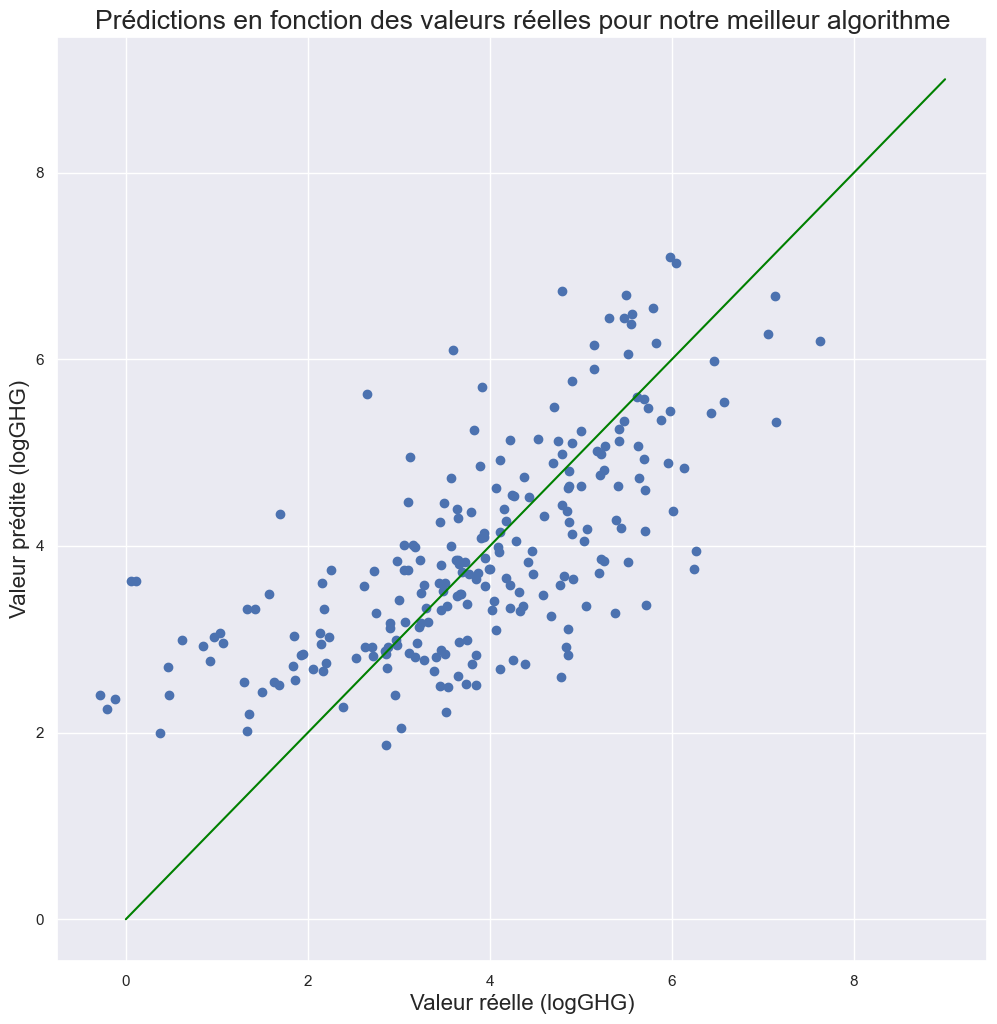

In [37]:
Y_pred = realbestgbr.predict(X_test_scaled)

fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(Y_test,Y_pred)
plt.plot([0,9],[0,9],color='green') #Pour tracer l'identité, droite sur laquelle nos points seraient tous si l'algorithme était parfait
plt.title("Prédictions en fonction des valeurs réelles pour notre meilleur algorithme", fontsize = 19)
plt.xlabel("Valeur réelle (logGHG)", fontsize = 16)
plt.ylabel("Valeur prédite (logGHG)", fontsize = 16)
plt.show()

Je trouve cela un peu moins flagrant ici. Toutefois, en comparant directement avec la target précédente, on se rend bien compte que la densité de valeurs autour de l'identité est plus faible pour cette target.

### Analyse des features

On essaie de constater, à nouveau, comment le modèle prend ses décisions.
On s'attend à observer la même chose que pour la première target. C'est-à-dire une domination nette de la part du GFATotal.

In [38]:
#Pour mon meilleur modèle, le Gradient Boosting initialisé.
explainer = shap.KernelExplainer(realbestgbr.predict, shap.sample(X_scaled,50))
shap_values = explainer.shap_values(shap.sample(X_test_scaled,50))


  0%|          | 0/50 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

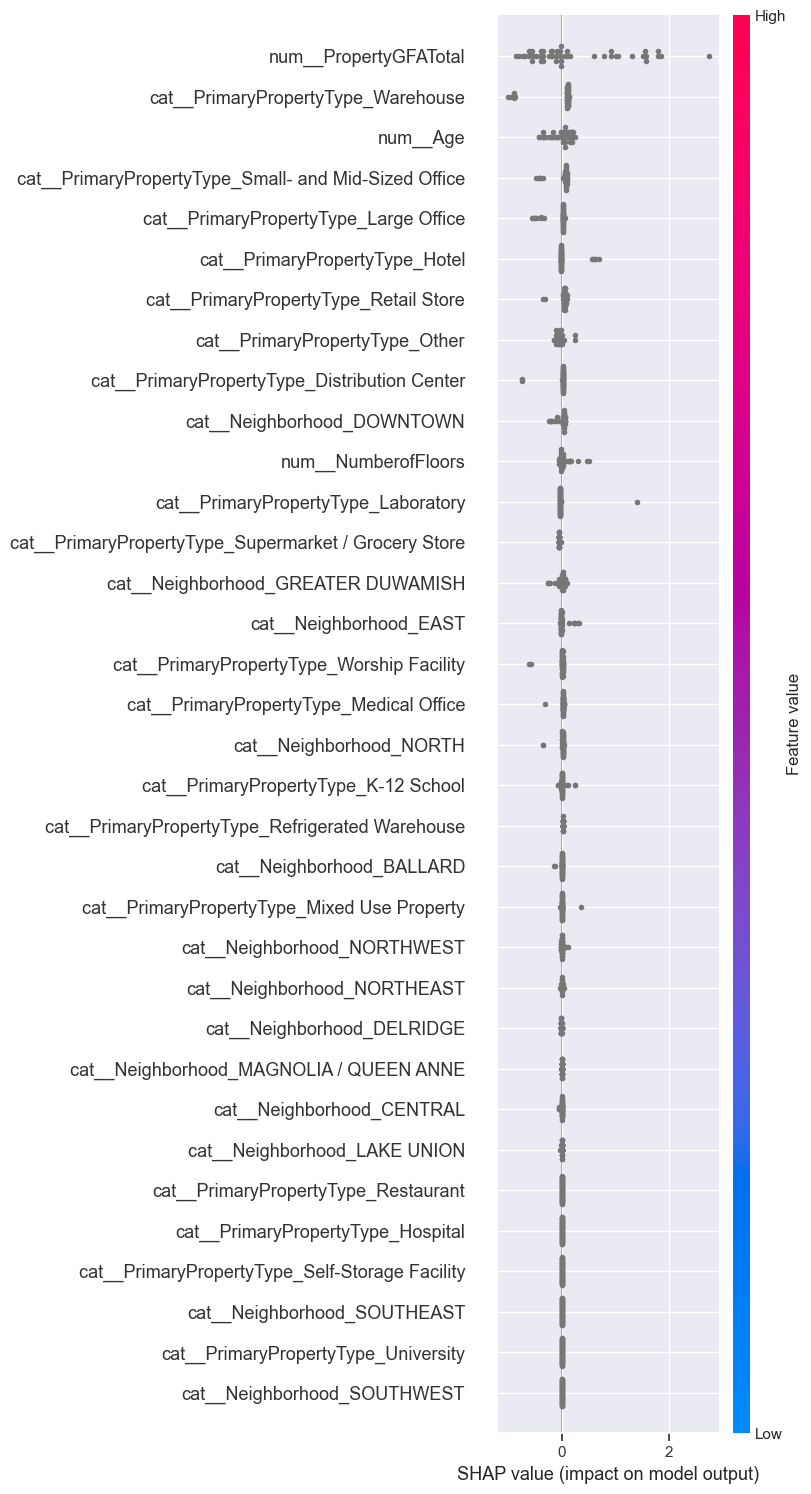

In [39]:
shap.summary_plot(shap_values,
                  features = X_test_scaled,
                  feature_names = features,
                  max_display = 34)
             

En effet, comme on pouvait s'y attendre, les features les plus importantes sont les mêmes pour une target comme pour l'autre. Et en effet, la surface totale domine largement.

## Pertinence de la variable EnergySTARScore

### Traitement des valeurs manquantes

Enfin, testons tout de même l'impact de la présence de l'energystarscore (ESS) sur cette target, à titre informatif, même si on sait pertinemment qu'à cause de son mode de calcul, on ne peut pas raisonnablement l'utiliser en réalité.

In [40]:
data.loc[data["ENERGYSTARScore"].isna(),:].shape

(538, 9)

In [41]:
data.shape

(1583, 9)

In [42]:
#On va perdre a peu près 1/3 des données.
data_ess = data.loc[~(data["ENERGYSTARScore"].isna()),:]



In [43]:
#On sépare les données pour isoler la target
Y = data_ess["logGHG"].round(3)

X = data_ess.loc[:, ["PrimaryPropertyType","Neighborhood","NumberofFloors","PropertyGFATotal","Age","ENERGYSTARScore"]] 


#Il nous faut de nouveau un jeu d'entrainement et un jeu de test

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, stratify = X["PrimaryPropertyType"])

#On doit de nouveau scaler et encoder.

numeric_features = ["NumberofFloors","PropertyGFATotal","Age","ENERGYSTARScore"]

categorical_features = ["PrimaryPropertyType","Neighborhood"]

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

X_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.fit_transform(X_test)

A présent, je teste mes meilleurs algorithmes avec ces nouveaux datasets.

In [44]:
errors = pd.DataFrame(columns = ['Algorithm', 'Best MSE', 'RMSE','MAE','r2'])

params = {
        'gamma' : np.logspace(-3,0,4),
        'C' : np.logspace(0,3,4),
        'epsilon' : [0.05,0.1,0.15],
        'kernel' : ['rbf']
    }

bestrbfsvr = test_this_model(SVR, params)

MSE de base : 1.042
Meilleure MSE : 0.948
Meilleurs paramètres : {'C': 100.0, 'epsilon': 0.15, 'gamma': 0.01, 'kernel': 'rbf'}


In [45]:
params = {
        'degree' : [3,4],
        'gamma' : np.logspace(-2,1,4),
        'alpha' : np.logspace(0,3,4),
        'coef0' : np.logspace(-1,2,4),
        'kernel' : ['poly']
    }

bestkrrpoly = test_this_model(KernelRidge, params)

MSE de base : 1.097
Meilleure MSE : 0.921
Meilleurs paramètres : {'alpha': 100.0, 'coef0': 10.0, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}


In [46]:
params = {
        'gamma' : np.logspace(-4,1,6),
        'alpha' : np.logspace(-3,3,7),
        'kernel' : ['rbf']
    }

bestkrrrbf = test_this_model(KernelRidge, params)

MSE de base : 1.097
Meilleure MSE : 0.909
Meilleurs paramètres : {'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


In [47]:
params = {
    'learning_rate' : np.logspace(-3,-1,3),
    'n_estimators' : [100, 500, 1000]
}

bestgbr = test_this_model(GradientBoostingRegressor, params)

MSE de base : 1.140
Meilleure MSE : 1.156
Meilleurs paramètres : {'learning_rate': 0.01, 'n_estimators': 1000}


In [48]:
params = {
    'init' : [bestkrrpoly, bestkrrrbf, bestrbfsvr], #Ces trois là sont toujours les meilleurs et assez proches
    'learning_rate' : np.logspace(-3,-1,3),
    'n_estimators' : [100, 500, 1000]
}

realbestgbr = test_this_model(GradientBoostingRegressor, params)

MSE de base : 1.143
Meilleure MSE : 1.044
Meilleurs paramètres : {'init': KernelRidge(alpha=100.0, coef0=10.0, gamma=0.1, kernel='poly'), 'learning_rate': 0.01, 'n_estimators': 500}


In [49]:
errors["Algorithm"] = ["SVR rbf", "KernelRidgePoly","KernelRidge rbf","Gradient Boost","Initialized Gradient Boost"]

In [50]:
errors = errors.sort_values("Best MSE").reset_index(drop = True)

In [51]:
errors

,Algorithm,Best MSE,RMSE,MAE,r2
0,KernelRidge rbf,0.908673,0.953244,0.760672,0.521597
1,KernelRidgePoly,0.920904,0.959637,0.764983,0.460406
2,SVR rbf,0.947609,0.973452,0.759700,0.462522
3,Initialized Gradient Boost,1.044391,1.021954,0.823411,0.546031
4,Gradient Boost,1.155934,1.075144,0.858138,0.464822


#### Premiers constats

De nouveau, l'ajout de cette feature permet une amélioration très conséquente sur toutes les métriques observées. Il est vraiment regrettable que ce soit aussi biaisé.


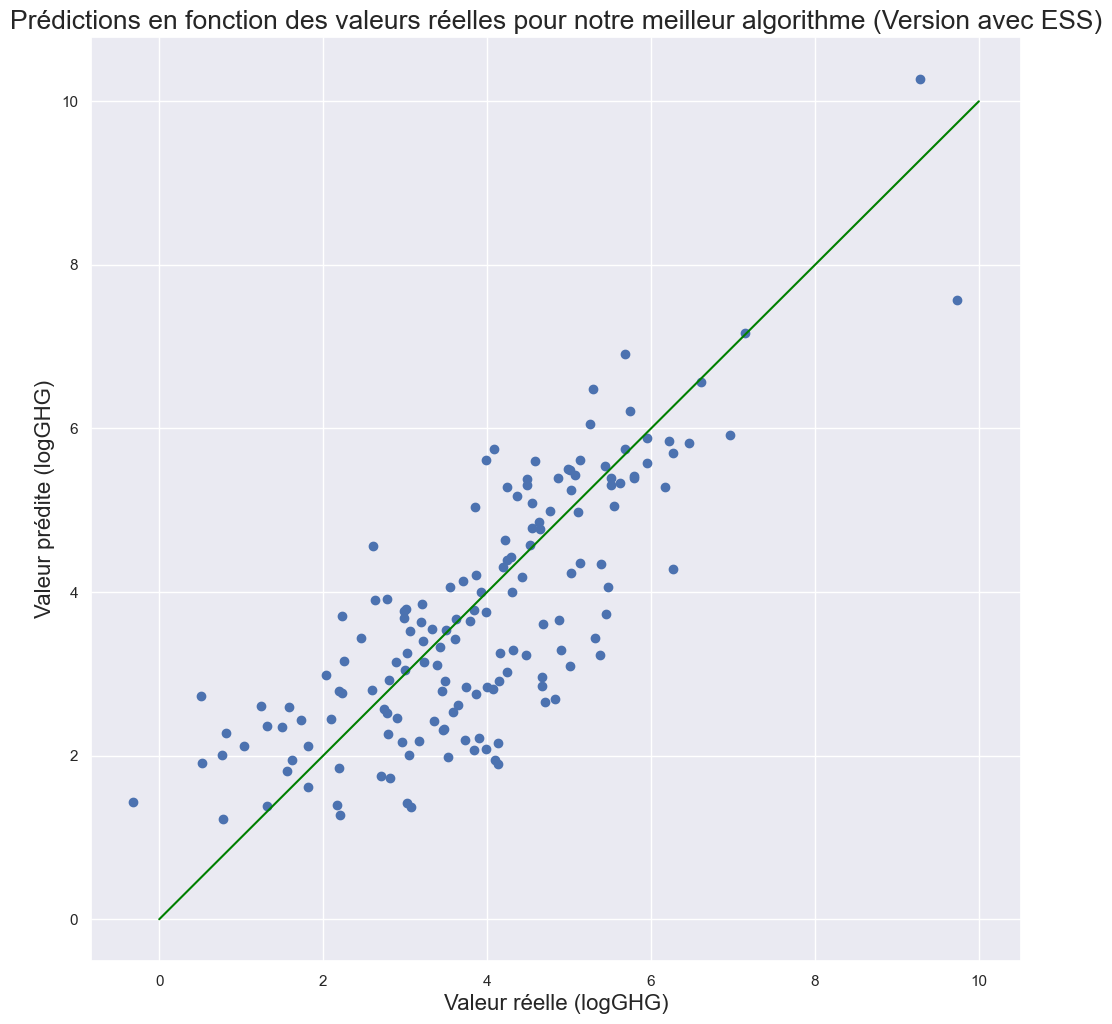

In [52]:
#On peut aussi reproduire ce graphique

Y_pred = realbestgbr.predict(X_test_scaled)

fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(Y_test,Y_pred)
plt.plot([0,10],[0,10],color='green') #Pour tracer l'identité, droite sur laquelle nos points seraient tous si l'algorithme était parfait
plt.title("Prédictions en fonction des valeurs réelles pour notre meilleur algorithme (Version avec ESS)", fontsize = 19)
plt.xlabel("Valeur réelle (logGHG)", fontsize = 16)
plt.ylabel("Valeur prédite (logGHG)", fontsize = 16)
plt.show()

On constate également sur ce graphique que l'ensemble de nos points est très proche de l'identité ici. Cela signifie que nos prédictions sont assez précises (logarithmiquement).

## Conclusions globales

#### Le meilleur modèle

Que ce soit pour une target autant que pour l'autre, il est difficile de donner une conclusion sur le meilleur modèle. En effet, le fait d'avoir si peu de données fait que le random_state de notre train/test/split fait *vraiment* beaucoup varier nos résultats. Non seulement en terme de valeur de nos mesures de précision (R², MSE notablement), mais aussi en terme de classement des meilleurs modèles.

Je peux néanmoins avancer que, ayant pu observer de nombreux "jets" aléatoires dudit train/test/split, les meilleurs modèles sont, de loin, les modèles à noyaux ainsi que le gradient boosting. 

De plus, parmi tous ceux là, celui qui se dégage légèrement est le gradient boosting initialisé avec le meilleur des modèles à noyaux.

C'est donc vers lui que je me dirigerais, en essayant de le confronter à plus de données, si possible, pour stabiliser les résultats.

#### L'Energy STAR score

Comme je l'ai dit déjà dans le notebook précédent (je vous renvoie à ces conclusions pour une version plus longue), s'il n'utilisait pas les targets dans son mode de calcul, et avec les mêmes valeurs, il serait une feature très importante pour nos prédictions, et permettrait de les améliorer très nettement, pour les deux targets.

Hélas, cela n'a aucun sens de l'utiliser, puisque pour le calculer, il faut déjà connaître les targets. Il n'y a donc plus rien à prédire.

#### Feature importance

De toutes les features qu'on a à disposition, c'est la surface globale qui impacte, de loin, le plus fortement nos prédictions. C'est tout à fait conforme à ce qu'on avait intuité lors de l'analyse exploratoire.

De plus, encore une fois comme dans l'analyse exploratoire, ce que l'on avait constaté concernant les types de bâtiments (certains consomment beaucoup (e.g. hôpitaux), d'autres très peu (e.g. entrepôts)) est également un facteur impactant. Presque autant que la surface pour les bâtiments concernés.

#### Pertinence des prédictions

Je ne suis jamais retourné aux valeurs réelles. Je suis resté sur des logarithmes tout au long de mes tentatives de prédiction. 
Cela signifie qu'une MSE de 0.5, par exemple, sur le logEnergyUse, correspond en fait à une erreur d'un facteur multiplicatif d'environ 1.65

C'est beaucoup et peu à la fois. Au vu des unités globales, je dirais intuitivement que c'est satisfaisant. Toutefois, il me faudrait discuter avec des spécialistes du domaine pour le confirmer, puisque je ne sais pas tout à fait ce que représente un kBtu. Je sais simplement qu'en terme d'ordre de grandeur, on va très rarement se tromper (sauf sur les valeurs les plus faibles qu'on a du mal à prédire).

En revanche, les résultats sont beaucoup moins satisfaisants sur les émissions de gaz à effet de serre. En effet, le facteur multiplicatif réel dépasse souvent 3, et on a donc un risque non négligeable de se tromper d'un ordre de grandeur, ce qui n'est pas rien.

## Ouvertures : Ce que j'aurais pu faire de plus

#### Pousser le traitement de l'erreur en 'MSE réelle'

J'ai longtemps pensé créer une fonction d'erreur consistant à repasser mon logEnergyUse en EnergyUse, calculer l'erreur quadratique, et essayer de minimiser cela. J'en ai déjà parlé dans le notebook précédent, et notamment évoqué les raisons qui m'ont poussé à ne pas le faire. Toutefois, c'est une piste qui existe.

#### Ajouter une feature

Après relecture de mon travail, je me dis que la disparition de la feature "GFABuilding" a été un peu rapide.
J'aurais pu, probablement, utiliser un ratio GFABuilding/GFATotal. Il aurait très souvent valu 1, mais mes variables OneHot encodées aussi, alors pourquoi pas. 
Pour les mêmes raisons, peut-être que le NumberOfBuildings aurait pu rester.

Cela aurait-il été plus performant ? Peut-être. Probablement pas de beaucoup dans tous les cas. 
Cela aurait-il valu la peine d'esssayer ? Probablement.

#### La target : Source ou Site

Encore une fois, cette question aurait pu se régler avec des spécialistes de terrain, ou bien en demandant explicitement à Douglas, le project lead. En réalité, je me dis surtout que la variable catégorielle "Neighborhood", très peu impactante dans mes prédictions sur le "Site", aurait peut-être eu son mot à dire avec les target "Source"

#### SecondMostUsedPropertyType

Lors de l'analyse, j'ai fait beaucoup de tri autour des variables "Type", globalement. Il y en avait tellement que je n'ai pas eu le courage d'aller digresser encore plus loin dans cette direction, pour les bâtiments qui avaient plusieurs types "principaux" d'utilisation (vérifables car on avait également la surface).

Il y avait peut-être quelque chose à faire à ce niveau, soit en séparant en deux (ou trois le cas échéant) les lignes en question, soit autrement de manière plus fine, mais je ne suis pas convaincu que ç'eut été aussi simple que ça. 

Mais c'est encore une piste, potentiellement intéressante.